# Random Forest Classifier

In [1]:
# Model Resource:  https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [61]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pathlib import Path
import time
import hvplot.pandas

#Import SKLearn Library and CLasses
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from joblib import dump, load

import yfinance as yf
import pyfolio as pf
from pyfolio import timeseries 
import matplotlib.pyplot as plt

#%matplotlib inline

In [62]:
# Load model parameter file
df_random_forest_model_param = pd.read_csv('DataFiles/random_forest_model_parameters.csv', index_col=0)
df_random_forest_model_param

,RFC_Parameter_Value
RFC_Parameters,
TrainSplit,0.7
n_estimators,500
criterion,gini
max_depth,5000
min_samples_split,2
min_samples_leaf,1
min_weight_fraction_leaf,0
max_features,5
max_leaf_nodes,None


In [63]:
# Load lag results from notebook 'rfc_model_optimal_lag.ipynb'
# The results of this notebook should equal the values in 'df_strat_lag' for a given lag value
df_strat_lag = pd.read_csv('AutoOutputFiles/df_strat_lag.csv', index_col=0)
df_strat_lag

,RunDate,PeriodEndDate,FeatureLag,n_estimators,max_depth,max_features,random_state,verbose,Annual Return,Annual Volatility,Sharpe Ratio,Calmar Ratio,Max Drawdown,Sortino Ratio,Alpha,Beta
0,2021-10-19,2021-10-15,1,500,5000,auto,0,1,0.124655,0.172628,0.767984,0.415464,-0.300037,1.032716,-0.003581,0.581431
1,2021-10-19,2021-10-15,2,500,5000,auto,0,1,0.079568,0.161032,0.556439,0.334148,-0.238123,0.762579,-0.028447,0.505847
2,2021-10-19,2021-10-15,3,500,5000,auto,0,1,0.033058,0.199214,0.263685,0.096158,-0.343791,0.355596,-0.121017,0.774969
3,2021-10-19,2021-10-15,4,500,5000,auto,0,1,0.295108,0.187509,1.473201,1.553248,-0.189994,2.245409,0.121942,0.688134
4,2021-10-19,2021-10-15,5,500,5000,auto,0,1,0.032203,0.198441,0.259709,0.113323,-0.284168,0.352546,-0.120655,0.768971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-10-19,2021-10-15,86,500,5000,auto,0,1,0.272538,0.172413,1.484159,1.887513,-0.144390,2.371159,0.127148,0.581463
86,2021-10-19,2021-10-15,87,500,5000,auto,0,1,0.099406,0.163227,0.662238,0.511348,-0.194400,0.936941,-0.013520,0.519705
87,2021-10-19,2021-10-15,88,500,5000,auto,0,1,0.098747,0.170735,0.638339,0.325219,-0.303633,0.826030,-0.023908,0.568712
88,2021-10-19,2021-10-15,89,500,5000,auto,0,1,0.143967,0.175928,0.852930,0.559869,-0.257143,1.211674,0.008648,0.603980


In [64]:
# Must have proper index for logic to work correctly
# Lag Value = Index Value + 1 (df_strat_lag index must start at index = 0 and be sequential)
column = df_strat_lag["Annual Return"]
max_value = column.max()
print(f'The highest Average Annualized Return = {max_value:.3%}')
max_index = column.idxmax()
#max_index
print(f'The highest Average Annualized Return Index = {max_index}')

optimal_lag = max_index + 1
print(f'The optimal Feature Lag to produce highest expected Average Annualized Return = {optimal_lag}')

The highest Average Annualized Return = 29.511%
The highest Average Annualized Return Index = 3
The optimal Feature Lag to produce highest expected Average Annualized Return = 4


In [65]:
#################################
#         GLOBAL VARIABLES      #
#################################

# Day's per annum
n = 252
# data shift
signal_shift = optimal_lag
print(f'The Feature Set will be lagged by {signal_shift} days with the objective of maximizing Average Annualized Return')

The Feature Set will be lagged by 4 days with the objective of maximizing Average Annualized Return


In [7]:
# Open signals file for feature set
feature_set_pct_path = Path('AutoOutputFiles/df_key_credit_data_usa_adjusted_pct.csv')
X = pd.read_csv(feature_set_pct_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
X.head()

,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC
Date,,,,,
1997-01-02,-0.022364,0.000000,0.000000,-0.015385,-0.013550
1997-01-03,0.009804,0.016667,0.000000,0.010417,0.012363
1997-01-06,0.003236,0.000000,0.024096,0.000000,-0.001357
1997-01-07,0.000000,0.000000,-0.011765,-0.005155,0.000000
1997-01-08,-0.009677,-0.016393,-0.011905,-0.010363,-0.002717


In [8]:
# Shift DataFrame Index by 1 to ensure we are using current day's values to predict the next days target value and drop NaNs that get produced in the first row from shift
# Used for model purposes

X = X.shift(signal_shift).dropna()

print(f'Feature dataset is ready for use and has a shape of {X.shape}')
X.head()

Feature dataset is ready for use and has a shape of (6384, 5)


,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC
Date,,,,,
1997-04-17,-0.022364,0.000000,0.000000,-0.015385,-0.013550
1997-04-18,0.009804,0.016667,0.000000,0.010417,0.012363
1997-04-21,0.003236,0.000000,0.024096,0.000000,-0.001357
1997-04-22,0.000000,0.000000,-0.011765,-0.005155,0.000000
1997-04-23,-0.009677,-0.016393,-0.011905,-0.010363,-0.002717


In [9]:
# Used for plotting and informational purposes only
feature_set_levels_path = Path('AutoOutputFiles/df_key_credit_data_usa_adjusted_levels.csv')
X_levels = pd.read_csv(feature_set_levels_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
X_levels.head()

,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC
Date,,,,,
1996-12-31,3.13,0.60,0.83,1.95,7.38
1997-01-02,3.06,0.60,0.83,1.92,7.28
1997-01-03,3.09,0.61,0.83,1.94,7.37
1997-01-06,3.10,0.61,0.85,1.94,7.36
1997-01-07,3.10,0.61,0.84,1.93,7.36


In [10]:
# Shift DataFrame Index by 1 to align with DataFrame = X
# Used for plotting and informational purposes only
X_levels = X_levels.shift(signal_shift).dropna()

print(f'Feature dataset is ready for use and has a shape of {X_levels.shape}')
X_levels.head()

Feature dataset is ready for use and has a shape of (6385, 5)


,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC
Date,,,,,
1997-04-16,3.13,0.60,0.83,1.95,7.38
1997-04-17,3.06,0.60,0.83,1.92,7.28
1997-04-18,3.09,0.61,0.83,1.94,7.37
1997-04-21,3.10,0.61,0.85,1.94,7.36
1997-04-22,3.10,0.61,0.84,1.93,7.36


In [11]:
# Construct a data frame for equity security (target/dependent variable)
tareget_set_levels_path = Path('AutoOutputFiles/df_equity_data.csv')
equity_data = pd.read_csv(tareget_set_levels_path, index_col="Date", infer_datetime_format=True, parse_dates=True)
equity_data.head()

,Close,EquityPriceReturns,PositiveReturn
Date,,,
2011-10-20,100.172401,0.004376,1
2011-10-21,102.074364,0.018987,1
2011-10-24,103.325935,0.012261,1
2011-10-25,101.316879,-0.019444,0
2011-10-26,102.346115,0.010159,1


In [12]:
# Concatenate the equity and credit dataframes for modelling
df_trading_signals = pd.concat([equity_data, X], axis='columns', join='inner')
print(f'The DataFrame named "df_trading_signals" constructed to hold Equity closing price levels, Equity daily returns, indication of positive, 1, and negative, 0, Equity returns.\n')
print(f'"df_trading_signals" has a shape of {df_trading_signals.shape}\n')
#df_trading_signals.to_csv('AutoOutputFiles/df_trading_signals_random_forest_version_0001.csv')
df_trading_signals.head()

The DataFrame named "df_trading_signals" constructed to hold Equity closing price levels, Equity daily returns, indication of positive, 1, and negative, 0, Equity returns.

"df_trading_signals" has a shape of (2499, 8)



,Close,EquityPriceReturns,PositiveReturn,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC
Date,,,,,,,,
2011-10-20,100.172401,0.004376,1,0.007194,0.012195,0.004902,0.007229,0.009879
2011-10-21,102.074364,0.018987,1,-0.005357,0.000000,0.000000,-0.004785,-0.006522
2011-10-24,103.325935,0.012261,1,-0.014363,-0.006024,-0.004878,-0.012019,-0.015317
2011-10-25,101.316879,-0.019444,0,0.003643,0.012121,0.009804,0.007299,0.003333
2011-10-26,102.346115,0.010159,1,0.005445,0.005988,0.004854,0.002415,0.006645


In [13]:
df_trading_signals.isnull().sum()

Close                 0
EquityPriceReturns    0
PositiveReturn        0
BAMLH0A0HYM2          0
BAMLC0A0CM            0
BAMLC0A4CBBB          0
BAMLH0A1HYBB          0
BAMLH0A3HYC           0
dtype: int64

## Model

#### Assign Training and Testing Windows

In [14]:
training_start = df_trading_signals.index.min().strftime(format='%Y-%m-%d')
training_end = '2018-12-14'
testing_start = '2018-12-15'
testing_end = df_trading_signals.index.max().strftime(format='%Y-%m-%d')

#### Define X and Y Training & Test Datasets

In [15]:
x_variables = ['BAMLH0A0HYM2', 'BAMLC0A0CM', 'BAMLC0A4CBBB','BAMLH0A1HYBB', 'BAMLH0A3HYC']

x_train = df_trading_signals[x_variables][training_start:training_end]
y_train = df_trading_signals['PositiveReturn'][training_start:training_end]
#x_train.tail()
#y_train.tail()

In [16]:
# Seperate X and Y Testing Datasets
x_test = df_trading_signals[x_variables][testing_start:testing_end]
y_test = df_trading_signals['PositiveReturn'][testing_start:testing_end]
#x_test.tail()
#y_test.tail()

#### Random Forest Classifier Paramerters

In [ ]:
# n_estimators: int, default=100
#    The number of trees in the forest.

# max_depth: int, default=None.  
#    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

# min_samples_split: int or float, default=2
#    The minimum number of samples required to split an internal node:
#    If int, then consider min_samples_split as the minimum number.
#    If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

# verbose: int, default=0
#    Controls the verbosity when fitting and predicting.

# max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
#    The number of features to consider when looking for the best split:
#    If int, then consider max_features features at each split.
#    If float, then max_features is a fraction and round(max_features * n_features) features are considered at each split.
#    If “auto”, then max_features=sqrt(n_features).
#    If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
#    If “log2”, then max_features=log2(n_features).
#    If None, then max_features=n_features.
#    Note: the search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than max_features features.

# Model Parameters
input_n_estimators = int(df_random_forest_model_param.loc['n_estimators'].values)
input_max_depth = int(df_random_forest_model_param.loc['max_depth'].values)
input_max_features = 'auto'
input_random_state = int(df_random_forest_model_param.loc['random_state'].values)
input_min_samples_split = int(df_random_forest_model_param.loc['min_samples_split'].values)
input_verbose = int(df_random_forest_model_param.loc['verbose'].values)    

# Confirm the parameters that are being used for building, training, and testing the model
#print(f'\n')
print(f'-'*55)
print(f'Training Data Sets:')
print(f'Training Start: {training_start}')
print(f'Training End: {training_end}')
print(f'Feature (Indepenendent Variables) Training Size: {len(x_train)}')
print(f'Target (Depenendent Variables) Training Size: {len(y_train)}')

print(f'-'*55)

print(f'Testing Data Sets:')
print(f'Testing Start: {testing_start}')
print(f'Testing End: {testing_end}')
print(f'Feature (Indepenendent Variables) Testing Size: {len(x_test)}')
print(f'Target (Depenendent Variables) Testing Size: {len(y_test)}')

print(f'-'*55)

print(f'The Random Forst Paramerters:')
print(f'n_estimators = {input_n_estimators}')
print(f'max_depth = {input_max_depth}')
print(f'max_max_features = {input_max_features}')
print(f'random_state = {input_random_state}')
print(f'-'*55)
print(f'\n')

#### Instantiate, Define, & fit the model

In [ ]:
model = RandomForestClassifier(
    n_estimators = input_n_estimators,
    max_depth = input_max_depth, 
    max_features = input_max_features, 
    random_state = input_random_state,
    min_samples_split = input_min_samples_split,
    verbose = input_verbose
)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assesmble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
results['PredictedValue'] = predictions
results.to_csv('AutoOutputFiles/results_testing.csv')

# Add a difference column to data frame, then plot to better visualize when actual and predicted are NOT equal
results['PredictedMinusActual'] = results['PredictedValue'] - results['PositiveReturn']
results.tail()

#### Calculate Strategy Performance & Determine Feature Importance using MDI

In [19]:
df_trading_signals.drop(columns=['PositiveReturn'], inplace=True)

df_performance_results = pd.concat([results, df_trading_signals], axis='columns', join='inner')
df_performance_results['Equity_Position'] = df_performance_results['PredictedValue'] * df_performance_results['EquityPriceReturns']
df_performance_results['Strategy_Cum_Rtn'] = ( 1 + df_performance_results['Equity_Position']).cumprod()
df_performance_results['Equity_Cum_Rtn'] = ( 1 + df_performance_results['EquityPriceReturns']).cumprod()
#df_performance_results['Treasury'] = sector_daily_returns['SPTS']
#df_performance_results.to_csv('AutoOutputFiles/df_performance_results_random_forest.csv')
df_performance_results.tail()

,PositiveReturn,PredictedValue,PredictedMinusActual,Close,EquityPriceReturns,BAMLH0A0HYM2,BAMLC0A0CM,BAMLC0A4CBBB,BAMLH0A1HYBB,BAMLH0A3HYC,Equity_Position,Strategy_Cum_Rtn,Equity_Cum_Rtn
Date,,,,,,,,,,,,,
2021-10-11,0,1,1,434.690002,-0.007240,-0.006579,0.011628,0.009346,-0.013699,-0.010292,-0.007240,1.700530,1.759384
2021-10-12,0,1,1,433.619995,-0.002462,0.006623,0.000000,0.000000,0.009259,0.000000,-0.002462,1.696344,1.755054
2021-10-13,1,0,-1,435.179993,0.003598,-0.003289,0.000000,0.000000,-0.004587,-0.001733,0.000000,1.696344,1.761368
2021-10-14,1,1,0,442.500000,0.016821,0.006601,0.000000,0.000000,0.009217,0.003472,0.016821,1.724878,1.790995
2021-10-15,1,0,-1,445.869995,0.007616,0.000000,0.011494,0.009259,-0.004566,0.001730,0.000000,1.724878,1.804635


Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, 
proportionally to the number of samples it splits.  In scikit-learn, it is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease
in node impurity weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.


The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars.
Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Elapsed time to compute the importances: 0.083 seconds


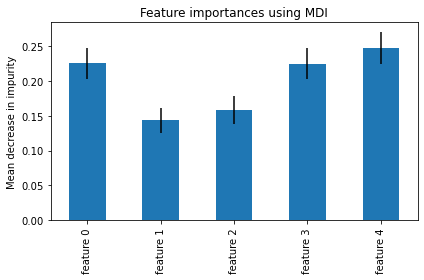

In [20]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
# https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
feature_names = [f'feature {i}' for i in range(X.shape[1])]
feature_names

msg = (f'Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, \n')
msg += (f'proportionally to the number of samples it splits.  ')
msg += (f'In scikit-learn, it is sometimes called “gini importance” or “mean decrease impurity” and is defined as the total decrease\nin node impurity ') 
msg += (f'weighted by the probability of reaching that node (which is approximated by the proportion of samples reaching that node)) averaged over all trees of the ensemble.\n\n')
print(msg)

start_time = time.time()
importances = model.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in model.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f'The blue bars are the feature importances of the forest, along with their inter-trees variability represented by the error bars.')
print(f'Feature importances are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.')
print(f'\nElapsed time to compute the importances: '
      f'{elapsed_time:.3f} seconds')

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

In [60]:
# Calculate the number of total trading days in test period (investable days)
# Using PredictedValue column which contains 0 & 1 values, thus count function used and not sum function
total_days = df_performance_results['PredictedValue'].count()
print(f'The total number of days in the testing period = {total_days}')

# Calculate the total number of postiive trading days in test period
# Using PositiveReturn column which contains 0 & 1 values; since we are only interested in values = 1, we can use sum function
# Calculate the % of positive trading days as function of total trading days
total_pos_days = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 1), 'PositiveReturn'].sum()
total_pos_days_pct = total_pos_days / total_days
total_pos_days_pct
print(f'The total number of postive return days in the testing period = {total_pos_days} or {total_pos_days_pct:.3%} of total days')

# Calculate the total number of negative trading days in period
# We can subtract total positive days from total days
# Calculate the % of negative trading days as a function of total trading days
total_neg_days = total_days - total_pos_days
total_neg_days_pct = total_neg_days / total_days
print(f'The total number of postive return days in the testing period = {total_neg_days} or {total_neg_days_pct:.3%} of total days')

# Calculate the number of days the strategy predictive a positive equity return day (days invested in equity security) 
# We can use the sum function as invested days = PredictedValue of 1 (negative days = 0)
# Calculate the % of invested days as a function of total trading days
strat_days_invested = df_performance_results['PredictedValue'].sum()
strat_days_invested_pct = strat_days_invested / total_days
print(f'The strategy had a long positions in the equity on {strat_days_invested} or {strat_days_invested_pct:.3%} of total days')

# Calculate the number of days invested in cash
# We can subtract invested days from total days to determine value
strat_days_in_cash = total_days - strat_days_invested
strat_days_in_cash_pct = 1 - strat_days_invested_pct
print(f'The strategy had long positions in cash on {strat_days_in_cash} or {strat_days_in_cash_pct:.3%} of total days')

# Upside Capture
# Calculate the number of days where invested in equity security and equity security had a positive return day
strat_days_invested_positive = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 1) & (df_performance_results['PredictedValue'] == 1), 'PredictedValue'].count()
strat_days_invested_positive_pct = strat_days_invested_positive / total_pos_days
print(f'The strategy captured {strat_days_invested_positive} of the equities postive return days or {strat_days_invested_positive_pct:.3%}')

# Downside Capture
# Calculate the number of days where invested in equity security and the equity security had a negative return day
strat_days_invested_negative = df_performance_results.loc[(df_performance_results['PositiveReturn'] == 0) & (df_performance_results['PredictedValue'] == 0), 'PredictedValue'].count()
strat_days_invested_negative_pct = strat_days_invested_negative / total_neg_days
print(f'The strategy captured {strat_days_invested_negative} of the equities negative return days or {strat_days_invested_negative_pct:.3%}')

# Total days where equity delivered return greater than or equal to 1%
#total_days_pos_extreme = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] >= 0) & (df_performance_results['PredictedValue'] == 0), 'PredictedValue'].count()
total_days_pos_extreme = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] >= 0.01), 'EquityPriceReturns'].count()
print(f'\nTotal days where equity delivered a return greater than or equal to 1%:  {total_days_pos_extreme}')

# Total days where equity delivered return less than or equal to -1%
#total_days_pos_extreme = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] >= 0) & (df_performance_results['PredictedValue'] == 0), 'PredictedValue'].count()
total_days_neg_extreme = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] <= -0.01), 'EquityPriceReturns'].count()
print(f'Total days where equity delivered a return less than or equal to -1%:  {total_days_neg_extreme}')

# Total days the strategy captured positive extreme return days
total_days_pos_extreme_invested = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] >= 0.01) & (df_performance_results['PredictedValue'] == 1), 'EquityPriceReturns'].count()
print(f'Total days the strategy captured positive extreme return days (>= 1%): {total_days_pos_extreme_invested}')

# Total days the strategy captured negative extreme return days
total_days_neg_extreme_invested = df_performance_results.loc[(df_performance_results['EquityPriceReturns'] <= -0.01) & (df_performance_results['PredictedValue'] == 1), 'EquityPriceReturns'].count()
print(f'Total days the strategy captured negative extreme return days (<= -1%): {total_days_neg_extreme_invested}')

The total number of days in the testing period = 714
The total number of postive return days in the testing period = 412 or 57.703% of total days
The total number of postive return days in the testing period = 302 or 42.297% of total days
The strategy had a long positions in the equity on 417 or 58.403% of total days
The strategy had long positions in cash on 297 or 41.597% of total days
The strategy captured 238 of the equities postive return days or 57.767%
The strategy captured 123 of the equities negative return days or 40.728%

Total days where equity delivered a return greater than or equal to 1%:  115
Total days where equity delivered a return less than or equal to -1%:  79
Total days the strategy captured positive extreme return days (>= 1%): 62
Total days the strategy captured negative extreme return days (<= -1%): 49


In [22]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# Calculate Full Period Risk Adjusted Performance Results

#annualized_return_strategy = df_performance_results['Equity_Position'].mean() * n
#annualized_return_Equity = df_performance_results['daily_return'].mean() * n

#annualized_vol_strategy = df_performance_results['Equity_Position'].std() * np.sqrt(n)
#annualized_vol_Equity = df_performance_results['daily_return'].std() * np.sqrt(n)

#sharpe_ratio_strategy = annualized_return_strategy / annualized_vol_strategy
#sharpe_ratio_Equity = annualized_return_Equity / annualized_vol_Equity

#variance_strategy = df_performance_results['Equity_Position'].var()
#variance_Equity = df_performance_results['daily_return'].var()

#beta_strategy = df_performance_results['Equity_Position'].cov(df_performance_results['daily_return']) / variance_Equity

In [23]:
# Retain should Pyfolio fail.  Only retaining in this module and deleting code block from other random forest model versions
# As long as Pyfolio continues to work, the following is not required

#dash_size = 55

#print(f'_'*dash_size)
#print()
#print(f'FULL TEST PERIOD PERFORMANCE RESULTS\nVALIDATE PYFOLIO & INCLUDES BETA')
#print(f'_'*dash_size)
#print(f'Strategy Annualized Return     = {annualized_return_strategy}')
#print(f'Equity Annualized Return          = {annualized_return_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized Volatility = {annualized_vol_strategy}')
#print(f'Equity Annualized Volatility      = {annualized_vol_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Annualized SR         = {sharpe_ratio_strategy}')
#print(f'Equity Annualized SR              = {sharpe_ratio_Equity}')
#print(f'-'*dash_size)
#print(f'Strategy Beta                  = {beta_strategy}')
#print(f'_'*dash_size)

In [24]:
# Highlights text on Master_Algo_Notebook.ipynb
print("\033[1;37;40m \033[2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          \033[0;37;40m")

 [2;37:40m          PYFOLIO PERFORMANCE TEAR SHEETS          


In [25]:
# Modify data frame dates to confirm to Pyfolio date requirements
df = df_performance_results
df = df.tz_localize("UTC")

In [26]:
algo_performance_series = df['Equity_Position']
Equity_performance_series = df['EquityPriceReturns']

perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=algo_performance_series, factor_returns=Equity_performance_series, positions=None, transactions=None, turnover_denom="USD")
#perf_stats_all.to_csv('AutoOutputFiles/random_forest_model_1_pyfolio_performance.csv')

In [27]:
print(f'\n\nTRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



TRADING ALGO TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return           0.212165
Cumulative returns      0.724878
Annual volatility       0.170673
Sharpe ratio            1.212014
Calmar ratio            2.453193
Stability               0.927419
Max drawdown           -0.086485
Omega ratio             1.387672
Sortino ratio           1.985035
Skew                    1.662455
Kurtosis               19.428749
Tail ratio              1.029009
Daily value at risk    -0.020682
Alpha                   0.076391
Beta                    0.568926
dtype: float64


In [28]:
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func(returns=Equity_performance_series, factor_returns=Equity_performance_series, positions=None, transactions=None, turnover_denom="USD")
#perf_stats_all.to_csv('AutoOutputFiles/random_forest_Equity_pyfolio_performance.csv')

In [29]:
print(f'\n\nEquity TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:\n{perf_stats_all}')



Equity TEST PERIOD PERFORMANCE RESULTS FROM PYFOLIO:
Annual return           0.231659
Cumulative returns      0.804635
Annual volatility       0.226189
Sharpe ratio            1.035355
Calmar ratio            0.687063
Stability               0.857729
Max drawdown           -0.337173
Omega ratio             1.240530
Sortino ratio           1.437898
Skew                   -0.706456
Kurtosis               14.579113
Tail ratio              0.808180
Daily value at risk    -0.027568
Alpha                   0.000000
Beta                    1.000000
dtype: float64


In [30]:
# Visualize cummulative returns, along with model false positive (value = 1), false negative (value = -1), and correct (value = 0) 
equity_cum_ret = df_performance_results[['Equity_Cum_Rtn']].hvplot(
    title= 'Equity Security (Black Line), Strategy Cummulative Return (Green Line)\nGrey Line, Predicted vs. Actual (Grey Line)',
    line_color='black',
    ylabel='Cummulative Return',
    width=1000,
    height=800)

strat_cum_perf = df_performance_results[['Strategy_Cum_Rtn']].hvplot(
    title= 'Equity Security (Black Line) vs. Strategy Cummulative Return (Green Line)',
    line_color='green',
    ylabel='Cummulative Return',
    width=1000,
    height=800)

pred_values = df_performance_results[['PredictedMinusActual']].hvplot(
    title= 'Equity Security (Grey Line) vs. Strategy Cummulative Return (Green Line)',
    line_color='lightgray',
    ylabel='Cummulative Return',
    width=1000,
    height=800)

comb_plot_full = equity_cum_ret * strat_cum_perf * pred_values
comb_plot_full

:Overlay
   .Curve.I   :Curve   [Date]   (Equity_Cum_Rtn)
   .Curve.II  :Curve   [Date]   (Strategy_Cum_Rtn)
   .Curve.III :Curve   [Date]   (PredictedMinusActual)

In [31]:
# Visualize ONLY cummulative returns (cleaner plot to isolate where strategy does a good job avoiding the severe downside  

### ******* NEED TO CHANGE TITLE **********
comb_plot_subset = equity_cum_ret * strat_cum_perf
comb_plot_subset

:Overlay
   .Curve.I  :Curve   [Date]   (Equity_Cum_Rtn)
   .Curve.II :Curve   [Date]   (Strategy_Cum_Rtn)

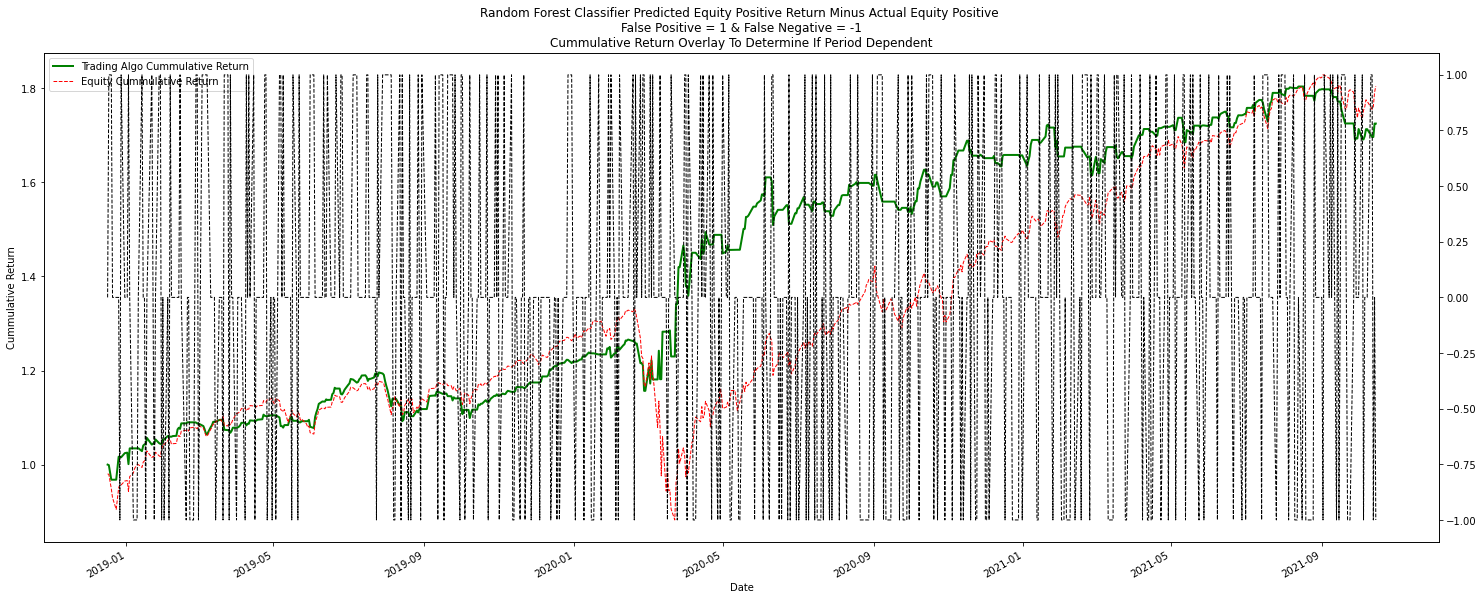

In [32]:
ax = df_performance_results['Strategy_Cum_Rtn'].plot(
    kind='line', label='Trading Algo Cummulative', legend=True, 
    title='Random Forest Classifier Predicted Equity Positive Return Minus Actual Equity Positive \nFalse Positive = 1 & False Negative = -1\nCummulative Return Overlay To Determine If Period Dependent', 
    secondary_y=False, 
    linewidth=2, 
    style='g', 
    figsize=(25,10)
)

ax2 = df_performance_results['Equity_Cum_Rtn'].plot(
    kind='line', 
    label='Equity Cummulative Return', 
    legend=True, 
    secondary_y=False, 
    linestyle='dashed', 
    linewidth=1, 
    style='r', 
    figsize=(25,10)
)

ax3 = df_performance_results['PredictedMinusActual'].plot(
    kind='line', 
    label='Equity Cummulative Return', 
    legend=True, 
    secondary_y=True, 
    linestyle='dashed', 
    linewidth=1, 
    style='black', 
    figsize=(25,10)
)


ax.legend(loc=0)
ax.set_ylabel('Cummulative Return')

ax.legend(
    [
        'Trading Algo Cummulative Return',
        'Equity Cummulative Return'
    ]
)

In [33]:
print("\033[1;37;40m \033[2;37:40m Random Forest Classifier Trading Algo Testing Period  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')

 [2;37:40m Random Forest Classifier Trading Algo Testing Period  
 [2;37:40m             Pyfolio Performance Tear Sheet            



Start date,2018-12-17
End date,2021-10-15
Total months,34
,Backtest
Annual return,21.217%
Cumulative returns,72.488%
Annual volatility,17.067%
Sharpe ratio,1.21
Calmar ratio,2.45
Stability,0.93
Max drawdown,-8.649%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.65,2019-07-26,2019-08-14,2019-12-12,100
1,8.61,2020-02-14,2020-02-27,2020-03-13,21
2,7.28,2020-03-30,2020-04-03,2020-04-14,12
3,6.29,2020-06-09,2020-06-11,2020-09-02,62
4,6.28,2021-08-17,2021-09-28,NaT,NaN


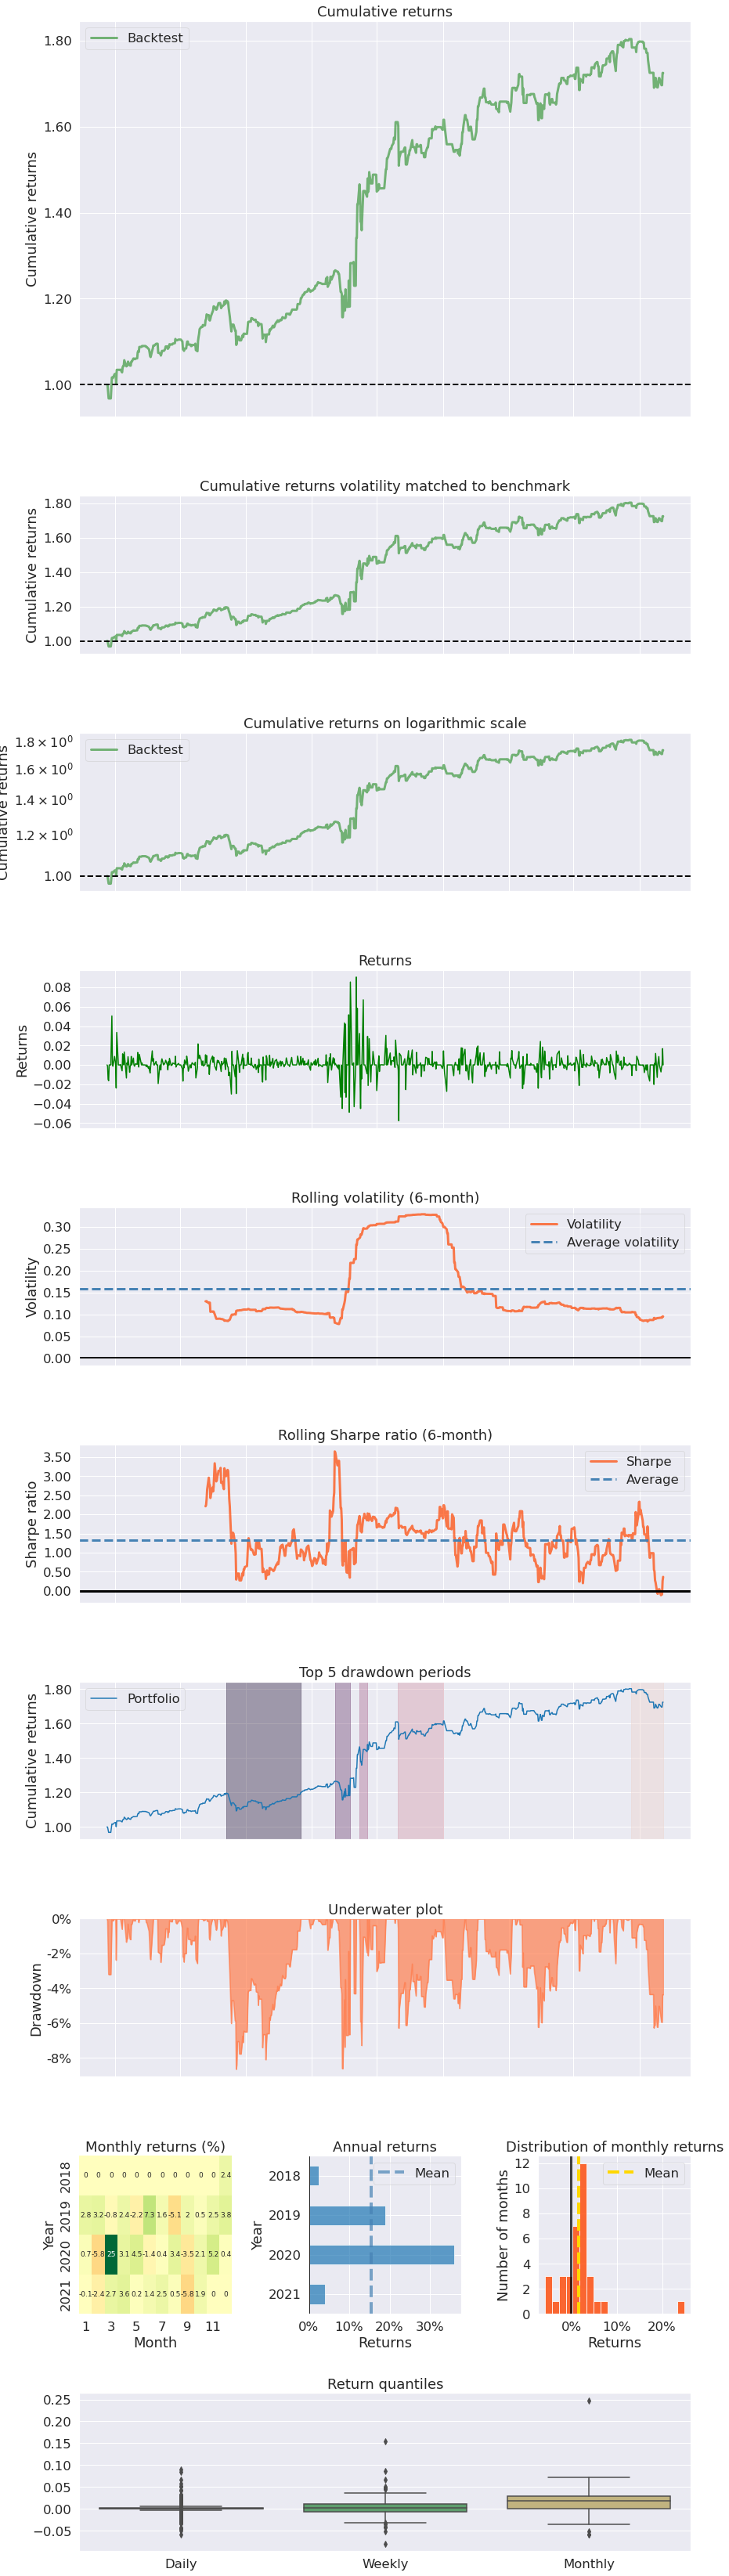

In [34]:
pf.create_returns_tear_sheet(algo_performance_series)

In [35]:
print('\n')
print("\033[1;37;40m \033[2;37:40m                   Equity Testing Period                  \033[0;37;40m")
print("\033[1;37;40m \033[2;37:40m             Pyfolio Performance Tear Sheet            \033[0;37;40m")
print('')



 [2;37:40m                   Equity Testing Period                  
 [2;37:40m             Pyfolio Performance Tear Sheet            



Start date,2018-12-17
End date,2021-10-15
Total months,34
,Backtest
Annual return,23.166%
Cumulative returns,80.463%
Annual volatility,22.619%
Sharpe ratio,1.04
Calmar ratio,0.69
Stability,0.86
Max drawdown,-33.717%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.72,2020-02-19,2020-03-23,2020-08-10,124
1,9.44,2020-09-02,2020-09-23,2020-11-11,51
2,7.70,2018-12-17,2018-12-24,2019-01-07,16
3,6.62,2019-05-03,2019-06-03,2019-06-20,35
4,6.02,2019-07-26,2019-08-05,2019-10-25,66


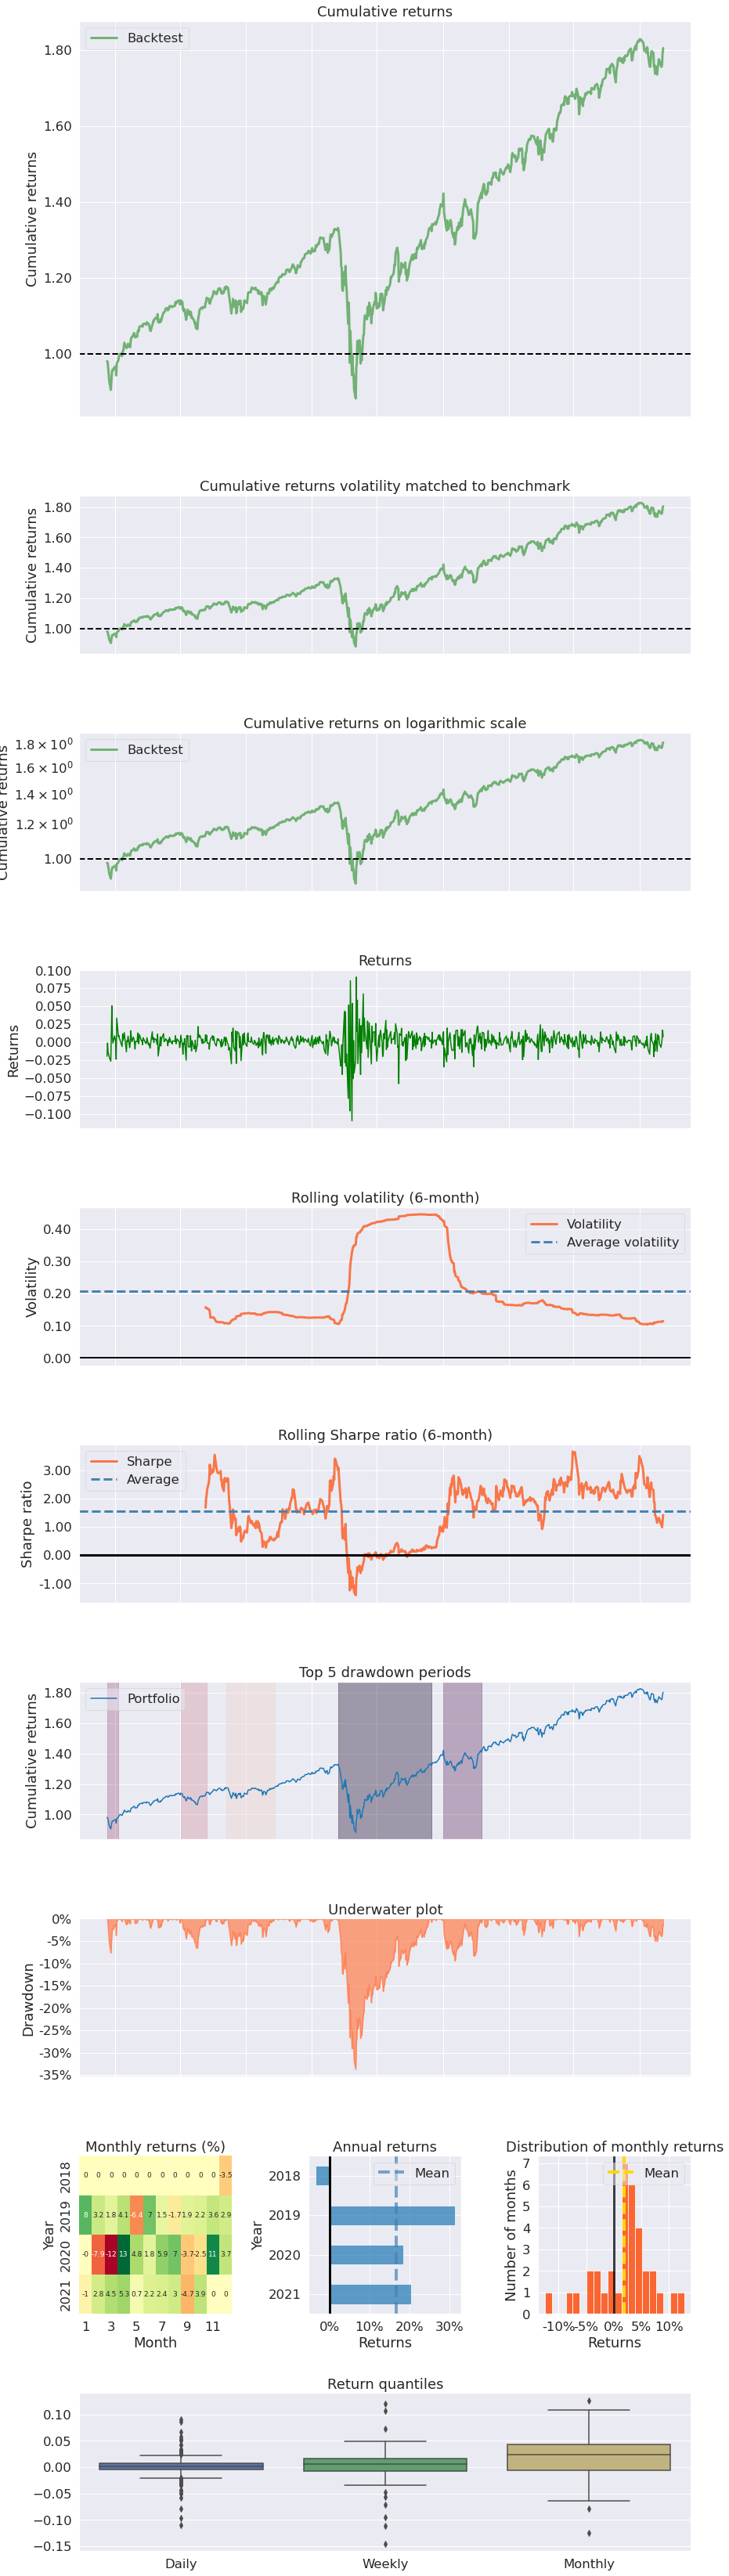

In [36]:
pf.create_returns_tear_sheet(Equity_performance_series)

In [37]:
# Retain in the event that Pyfolio fails
# Not required as long as pyfolio is working correctly

#ax = df_performance_results['Strategy_Cum_Rtn'].plot(
#    kind='line', label='Trading Algo Cummulative', legend=True, 
#    title='Testing Period\nTrading Algo vs. Equity Cummulative Return', secondary_y=False, linewidth=2, style='g', figsize=(20,5))

#ax2 = df_performance_results['Equity_Cum_Rtn'].plot(
#    kind='line', label='Equity Cummulative Return', secondary_y=False, legend=True, linestyle='dashed', linewidth=1, style='r', figsize=(20,5))

#ax.legend(loc=0)
#ax.set_ylabel('Cummulative Return')

#ax2.legend(loc=3)
#ax2.set_ylabel('Cummulative Return')

#ax.legend(
#    [
#        'Trading Algo Cummulative Return',
#        'Equity Cummulative Return'
#    ]
#)

In [38]:
# Define the performance measure window size for calcuation and plotting
measure_window_size_1 = 20
measure_window_size_2 = 60

# Calculate performance measures

# rolling covariance
strat_roll_period_1_covar_Equity = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).cov(df_performance_results['EquityPriceReturns'])
strat_roll_period_2_covar_Equity = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).cov(df_performance_results['EquityPriceReturns'])

# rolling variance
strat_roll_period_1_var = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).var()
strat_roll_period_2_var = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).var()
Equity_roll_period_1_var = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).var()
Equity_roll_period_2_var = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).var()

# rolling standard deviation
strat_roll_period_1_std = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).std()
strat_roll_period_2_std = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).std()
Equity_roll_period_1_std = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).std()
Equity_roll_period_2_std = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).std()

# rolling mean
strat_roll_period_1_mean = df_performance_results['Equity_Position'].rolling(window=measure_window_size_1).mean()
strat_roll_period_2_mean = df_performance_results['Equity_Position'].rolling(window=measure_window_size_2).mean()
Equity_roll_period_1_mean = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_1).mean()
Equity_roll_period_2_mean = df_performance_results['EquityPriceReturns'].rolling(window=measure_window_size_2).mean()


# rolling beta
strat_roll_period_1_beta = strat_roll_period_1_covar_Equity / Equity_roll_period_1_var
strat_roll_period_2_beta = strat_roll_period_2_covar_Equity / Equity_roll_period_2_var

# rolling sharpe ratio (not annualized; reflects the period sharpe ratio)
strat_roll_period_1_sharpe = strat_roll_period_1_mean / strat_roll_period_1_std
strat_roll_period_2_sharpe = strat_roll_period_2_mean / strat_roll_period_2_std
Equity_roll_period_1_sharpe = Equity_roll_period_1_mean / Equity_roll_period_1_std
Equity_roll_period_2_sharpe = Equity_roll_period_2_mean / Equity_roll_period_2_std

In [39]:
def chart_risk_measures_independent(title, performance_measure_name, performance_measure_data, Equity_cum_test_ret, algo_cum_test_ret):
    #chart_risk_measures(title, 'Beta', strat_roll_period_1_beta, strat_roll_period_2_beta, Equity_returns, algo_returns)
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    Equity_cum_test_ret reflects the cummulative return for Equity
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''
    ax = Equity_cum_test_ret.plot(
        kind = 'line',
        title = title,
        label = 'Equity Cummulative Return',
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'r',
        figsize=(20,5)
    )

    ax2 = algo_cum_test_ret.plot(
        kind='line',
        label='Trading Algo Cummulative',
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'g',
        figsize = (20,5)
    )    
    ax3 = performance_measure_data.plot(
        kind = 'line',
        label = 'Trading Algo Rolling Measure',
        legend = True,
        secondary_y = True,
        linestyle = 'dashed',
        linewidth = 1,
        style = 'b', 
        figsize = (20,5)
    )

    ax.legend(loc=0)
    ax2.legend(loc=0)
    ax3.legend(loc=3)

    ax.set_ylabel('Cummulative Return')
    ax3.set_ylabel(performance_measure_name)                                                    

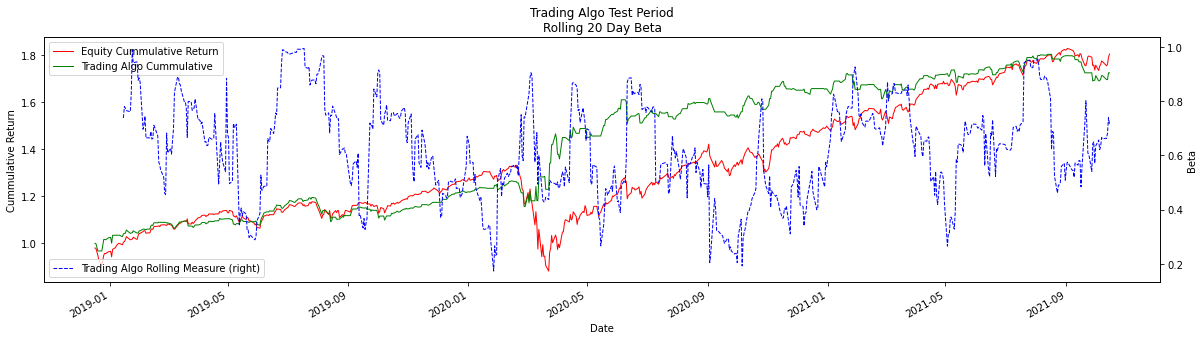

In [40]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_1} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_1_beta, df_performance_results['Equity_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

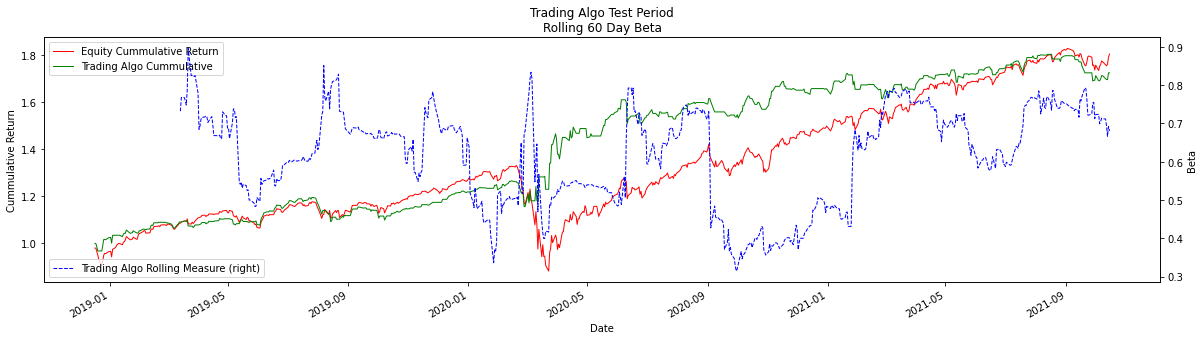

In [41]:
# Plot rolling period beta
title = (f'Trading Algo Test Period\nRolling {measure_window_size_2} Day Beta')
chart_risk_measures_independent(title, 'Beta', strat_roll_period_2_beta, df_performance_results['Equity_Cum_Rtn'], df_performance_results['Strategy_Cum_Rtn'])

In [42]:
def chart_comparables(title, df1, label1, df2, label2):
    '''
    This function accepts a title as string
    performance_measure as string and used for y_label
    period_1 & period_2 reflect the data containing the time series for which the performance measures
    Equity_cum_test_ret reflects the cummulative return for Equity
    algo_cum_test_ret reflects the cummulative return for the algo
    
    '''

    ax = df1.plot(
        kind = 'line',
        title = title,
        label = label1,
        secondary_y = False,
        legend = True,
        linewidth = 1,
        style = 'g',
        figsize=(20,5)
    )

    ax2 = df2.plot(
        kind = 'line',
        label = label2,
        legend = True,
        secondary_y = False,
        linewidth = 1,
        style = 'r',
        figsize = (20,5)
    )    

    ax.legend(loc=0)
    ax2.legend(loc=3)
    ax.set_ylabel('Rolling Period Sharpe Ratio')
    ax2.set_ylabel('Rolling Period Sharpe Ratio')

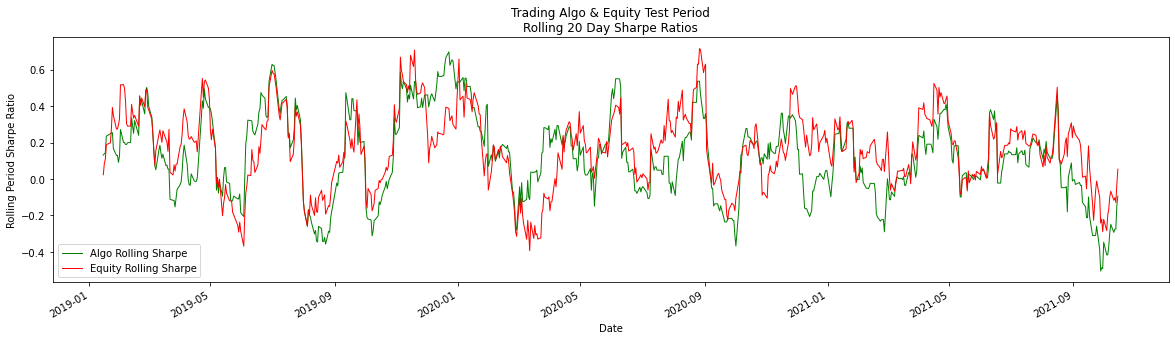

In [43]:
title = (f'Trading Algo & Equity Test Period\nRolling {measure_window_size_1} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'Equity Rolling Sharpe')
chart_comparables(title, strat_roll_period_1_sharpe, label1, Equity_roll_period_1_sharpe, label2)

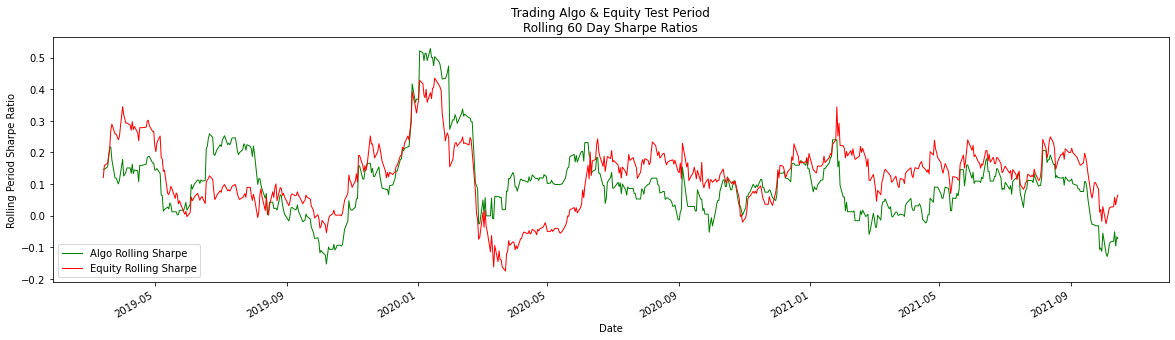

In [44]:
title = (f'Trading Algo & Equity Test Period\nRolling {measure_window_size_2} Day Sharpe Ratios')
label1 = (f'Algo Rolling Sharpe')
label2 = (f'Equity Rolling Sharpe')
chart_comparables(title, strat_roll_period_2_sharpe, label1, Equity_roll_period_2_sharpe, label2)

## Save Trained Model

In [45]:
dump(model, 'model_candidates/random_rorest_model_version_0001.joblib')

['model_candidates/random_rorest_model_version_0001.joblib']